In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from glob import glob
import cv2
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

In [2]:
label_dict = {'vehicle':0, 'scooter':1, 'bicycle':2, 'pedestrian':3 }

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## load testing data

In [3]:
class ImgDataset_test(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, filepath, transform=None):
        """
        Args:
            targets = dict that have bbox data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.filepath = filepath
        self.transform = transform
        self.label_dict = {'vehicle':0, 'scooter':1, 'bicycle':2, 'pedestrian':3 }

    def __len__(self):
        return len((self.filepath))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.filepath[idx]        
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        img_name = img_name.split('/')[-1]

        return image, img_name

In [4]:
test_image_dir = '../ivslab_test_public/JPEGImages/All/'
test_images = glob(test_image_dir+'*.jpg')

image_size = (800,800)

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor()])# [0-255] -> [0-1]


dataset_test = ImgDataset_test(test_images,transform)
print(dataset_test[0][1])
print(dataset_test[0][0].shape)

# 對 dataloader batch做最後處理的函式，不加會crash，原因我還沒搞懂
def collate_fn(batch):
    return tuple(zip(*batch))
testloader = DataLoader(dataset_test, batch_size=1,
                        shuffle=True, num_workers=0, collate_fn=collate_fn)

itp_775.jpg
torch.Size([3, 800, 800])


## create Model

In [5]:
model_ft = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 4+1
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## load Model

In [7]:
PATH = 'model/pytorch_fasterRCNN'

model_ft.load_state_dict(torch.load(PATH))
model_ft.eval() 
model_ft = model_ft.to(device)

In [8]:
outputs = list()

with torch.no_grad():
    for images, img_name in testloader:
        images = list(image.to(device) for image in images)
        output = model_ft(images)
        output = {k: v.to('cpu') for k, v in output[0].items()}
        output['name'] = img_name
        outputs.append(output)

In [41]:
test

{'boxes': tensor([[420.4157, 221.3737, 437.7368, 278.0524],
         [406.4814, 218.1327, 422.1107, 274.8091],
         [186.5077, 232.5469, 198.2885, 272.8652]]),
 'labels': tensor([1, 1, 1]),
 'scores': tensor([0.2182, 0.1810, 0.0541]),
 'name': ('itp_917.jpg',)}

In [9]:
outputs[0]

{'boxes': tensor([[3.2779e+02, 2.1253e+02, 4.7499e+02, 5.7444e+02],
         [1.2425e+01, 3.8193e+02, 2.4960e+02, 6.0281e+02],
         [1.9907e+02, 4.3221e+02, 3.2138e+02, 5.4330e+02],
         [4.8146e+02, 4.6320e+02, 4.9857e+02, 5.3174e+02],
         [1.0729e+02, 4.1659e+02, 2.7849e+02, 5.8743e+02],
         [7.3551e+02, 4.0687e+02, 8.0000e+02, 7.2229e+02],
         [4.7718e+02, 4.6114e+02, 4.9287e+02, 5.2802e+02],
         [4.7370e+02, 4.5964e+02, 4.8729e+02, 5.1903e+02],
         [4.5867e+02, 4.5009e+02, 4.7311e+02, 5.2056e+02],
         [6.7555e+02, 4.0450e+02, 7.8118e+02, 5.4218e+02],
         [3.3260e+02, 3.8050e+02, 4.6796e+02, 5.8016e+02],
         [4.9649e+02, 4.6733e+02, 5.0982e+02, 5.1675e+02],
         [2.4001e-01, 4.3100e+02, 2.5454e+01, 5.9452e+02],
         [1.7969e+02, 4.2954e+02, 2.8270e+02, 5.7006e+02],
         [4.6497e+02, 4.5673e+02, 4.7987e+02, 5.1975e+02],
         [7.4324e+02, 3.8525e+02, 7.9879e+02, 7.2913e+02],
         [4.8296e+02, 4.6196e+02, 5.1503e+02, 4

In [44]:
submission =  pd.DataFrame(columns = ["image_filename", "label_id", "x", "y", "w", "h", "confidence"])
output_dict = {'1':1, '2':3, '3':4, '4':2 }
threshold = 0.5

In [45]:
IMAGE_WIDTH = 800
IMAGE_HEIGHT = 800

for idx in range(len(outputs)):

    #Converting tensors to array
    boxes = outputs[idx]['boxes'].data.cpu().numpy()
    scores = outputs[idx]['scores'].data.cpu().numpy()
    labels = outputs[idx]['labels'].data.cpu().numpy()
    name = outputs[idx]['name'][0]

    #Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]

    # int_to_class - labels
    labels_th = []
    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(output_dict[str(labels[x])])

    #Appending results to csv
    for y in range(len(boxes_th)):

        #Bboxes, classname & image name
        x1 = boxes_th[y][0] * ( 1920 / IMAGE_WIDTH )
        y1 = boxes_th[y][1] * ( 1080 / IMAGE_HEIGHT)
        w = (boxes_th[y][2] - boxes_th[y][0]) * ( 1920 / IMAGE_WIDTH )
        h = (boxes_th[y][3] - boxes_th[y][1]) * ( 1080 / IMAGE_HEIGHT)
        class_name = labels_th[y]
        confidence = scores_th[y]

        #Creating row for df
        row = {"image_filename" : name, "label_id" : class_name, "x" : x1, "y" : y1, "w" : w, "h" : h,"confidence":confidence }
        #Appending to df
        submission = submission.append(row, ignore_index = True)

submission = submission.sort_values(by=['image_filename']).reindex()
submission.to_csv('test.csv',index=False)

In [46]:
submission.head()

,image_filename,label_id,x,y,w,h,confidence
2281,itp_1.jpg,1,43.2,519.75,175.2,171.45,0.999475
2291,itp_1.jpg,2,1418.4,548.10,24.0,82.35,0.567846
2290,itp_1.jpg,1,900.0,557.55,67.2,41.85,0.673401
2289,itp_1.jpg,3,919.2,552.15,40.8,74.25,0.674296
2288,itp_1.jpg,1,825.6,552.15,50.4,37.80,0.732682


## demo

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

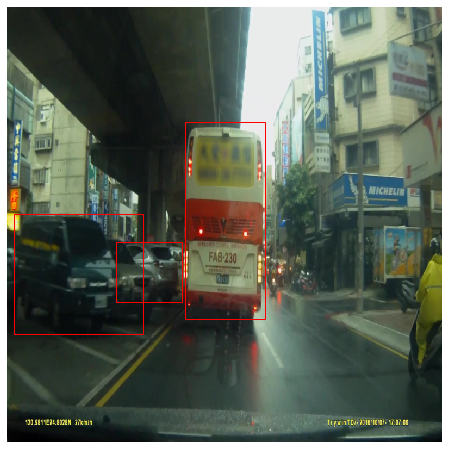

In [48]:
sample = [dataset_test[0][0].to(device)]
output = model_ft(sample)
output = [{k: v.to('cpu') for k, v in t.items()} for t in output]

sample_show = sample[0].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for pred in output:
    for box in pred['boxes'].detach().numpy().astype(np.int32)[0:3]:
            rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

ax.set_axis_off()


ax.imshow(sample_show)
plt.show()

In [49]:
dataset_test[0][1]

'itp_775.jpg'

In [50]:
output

[{'boxes': tensor([[3.2779e+02, 2.1253e+02, 4.7499e+02, 5.7444e+02],
          [1.2425e+01, 3.8193e+02, 2.4960e+02, 6.0281e+02],
          [1.9907e+02, 4.3221e+02, 3.2138e+02, 5.4330e+02],
          [4.8146e+02, 4.6320e+02, 4.9857e+02, 5.3174e+02],
          [1.0729e+02, 4.1659e+02, 2.7849e+02, 5.8743e+02],
          [7.3551e+02, 4.0687e+02, 8.0000e+02, 7.2229e+02],
          [4.7718e+02, 4.6114e+02, 4.9287e+02, 5.2802e+02],
          [4.7370e+02, 4.5964e+02, 4.8729e+02, 5.1903e+02],
          [4.5867e+02, 4.5009e+02, 4.7311e+02, 5.2056e+02],
          [6.7555e+02, 4.0450e+02, 7.8118e+02, 5.4218e+02],
          [3.3260e+02, 3.8050e+02, 4.6796e+02, 5.8016e+02],
          [4.9649e+02, 4.6733e+02, 5.0982e+02, 5.1675e+02],
          [2.4001e-01, 4.3100e+02, 2.5454e+01, 5.9452e+02],
          [1.7969e+02, 4.2954e+02, 2.8270e+02, 5.7006e+02],
          [4.6497e+02, 4.5673e+02, 4.7987e+02, 5.1975e+02],
          [7.4324e+02, 3.8525e+02, 7.9879e+02, 7.2913e+02],
          [4.8296e+02, 4.6196e+

In [51]:
submission.loc[submission['image_filename'] == 'itp_775.jpg']

,image_filename,label_id,x,y,w,h,confidence
0,itp_775.jpg,1,784.8,286.20,352.8,488.70,0.999791
1,itp_775.jpg,1,28.8,514.35,568.8,298.35,0.999314
2,itp_775.jpg,1,477.6,583.20,292.8,149.85,0.989397
3,itp_775.jpg,3,1154.4,625.05,40.8,91.80,0.970535
4,itp_775.jpg,1,256.8,561.60,410.4,230.85,0.931253
5,itp_775.jpg,3,1764.0,548.10,156.0,426.60,0.893858
6,itp_775.jpg,3,1144.8,622.35,36.0,90.45,0.748026
7,itp_775.jpg,3,1135.2,619.65,33.6,81.00,0.681634
8,itp_775.jpg,3,1099.2,607.50,36.0,94.50,0.668821
9,itp_775.jpg,1,1620.0,545.40,254.4,186.30,0.615400


In [43]:
submission.loc[submission['label_id'] == '1']

,image_filename,label_id,x,y,w,h,confidence


In [32]:
def plot_result(filename, boxes, reshape=False) :
    filename = '../ivslab_test_public/JPEGImages/All/' + filename
    img = cv2.imread(filename)
    
    if reshape:
        img = cv2.resize(img,(IMAGE_WIDTH, IMAGE_HEIGHT))
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        box = box.astype(np.int32)
        rect = patches.Rectangle((box[0],box[1]),box[2],box[3],
                                    linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    ax.set_axis_off()
    print(img.shape)
    ax.imshow(img)

(1080, 1920, 3)


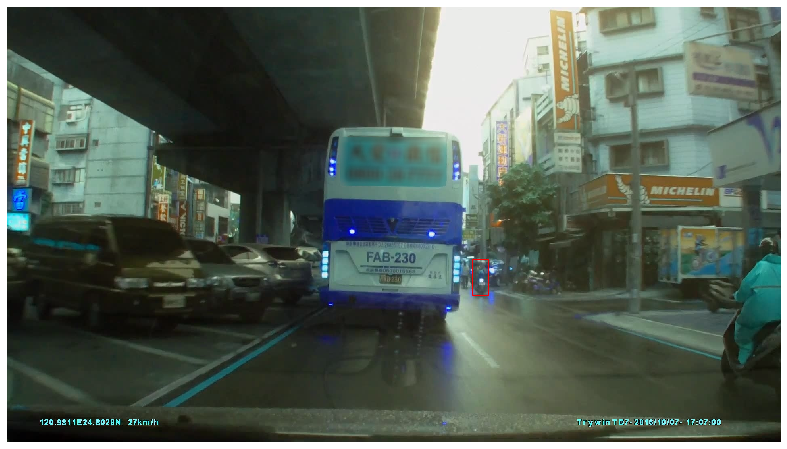

In [42]:
### original image
1154.4,625.05,40.8,91.80
boxes = np.array([[1154.4,625.05,40.8,91.80]])
filename = 'itp_775.jpg'
plot_result(filename,boxes)